# Quickstart for Deeplearning4j

Deeplearning4j - also known as "DL4J" - is a high performance domain-specific language to configure deep neural networks, which are made of multiple layers. Deeplearning4j is [open source](https://github.com/deeplearning4j/deeplearning4j/), written in C++, Java, Scala, and Python, and maintained by the Eclipse Foundation & community contributors.

### Before you get started

If you are having difficulty, we recommend you join our [Gitter chat](https://gitter.im/deeplearning4j/deeplearning4j). Gitter is a community where you can request help and give feedback, but please do use this guide before asking questions we’ve answered below. If you are new to deep learning, we’ve included a [road map for beginners](https://deeplearning4j.org/deeplearningforbeginners.html) with links to courses, readings and other resources. For a longer and more detailed version of this guide, please visiting the Deeplearning4j [Getting Started](https://deeplearning4j.org/gettingstarted) guide.

## Handwriting classification

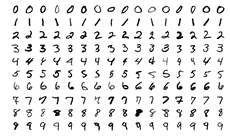

In this quickstart, you will create a deep neural network using Deeplearning4j and train a model capable of classifying random handwriting digits. While handwriting recognition has been attempted by different machine learning algorithms over the years, deep learning performs remarkably well and achieves an accuracy of over 99.7% on the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset. For this tutorial, we will classify digits in [EMNIST](https://www.nist.gov/itl/iad/image-group/emnist-dataset), the "next generation" of MNIST and a larger dataset.

This tutorial is written in Scala, a Java-based language that is well suited for notebooks like this one.

### What you will learn

1. Load a dataset for a neural network.
2. Format EMNIST for image recognition.
3. Create a deep neural network.
4. Train a model.
5. Evaluate the performance of your model.

### Prepare your workspace

Notebooks rely on an interpreter to execute the code inside of them. This notebook uses two different interpreters, [Markdown](https://zeppelin.apache.org/docs/0.7.1/interpreter/markdown.html) and [Spark](https://zeppelin.apache.org/docs/0.7.1/interpreter/spark.html). All of the text you've seen so far uses Markdown (and if you view the source code for the paragraph you'll see it starts with `%md` which calls for that paragraph to be executed by Markdown). Because the Spark interpreter is the default, the code you will see below does not explicity call for `%spark`.

Like most programming languages, you need to explicitly import the classes you want to use into scope. Below, we will import common Deeplearning4j classes that will help us configure and train a neural network. The code below is written in Scala.

Note we import methods from Scala's `JavaConversions` class because this will allow us to use native Scala collections while maintaining compatibility with Deeplearning4j's Java collections.

In [3]:
import scala.collection.JavaConversions._

import org.deeplearning4j.datasets.iterator._
import org.deeplearning4j.datasets.iterator.impl._
import org.deeplearning4j.nn.api._
import org.deeplearning4j.nn.multilayer._
import org.deeplearning4j.nn.graph._
import org.deeplearning4j.nn.conf._
import org.deeplearning4j.nn.conf.inputs._
import org.deeplearning4j.nn.conf.layers._
import org.deeplearning4j.nn.weights._
import org.deeplearning4j.optimize.listeners._
import org.deeplearning4j.datasets.datavec.RecordReaderMultiDataSetIterator
import org.deeplearning4j.eval.Evaluation

import org.nd4j.linalg.learning.config._ // for different updaters like Adam, Nesterovs, etc.
import org.nd4j.linalg.activations.Activation // defines different activation functions like RELU, SOFTMAX, etc.
import org.nd4j.linalg.lossfunctions.LossFunctions // mean squared error, multiclass cross entropy, etc.

### Prepare data for loading

Dataset iterators are important pieces of code that help batch and iterate across your dataset for training and inferring with neural networks. Deeplearning4j comes with a built-in implementation of a `BaseDatasetIterator` for EMNIST known as `EmnistDataSetIterator`. This particular iterator is a convenience utility that handles downloading and preparation of data.

Note that we create two different iterators below, one for training data and the other for for evaluating the accuracy of our model after training. The last `boolean` parameter in the constructor indicates whether we are instantiating test/train.

You won't need it for this tutorial, you can learn more about loading data for neural networks in this [ETL user guide](https://deeplearning4j.org/etl-userguide). DL4J comes with many record readers that can load and convert data into ND-Arrays from CSVs, images, videos, audio, and sequences.

In [5]:
import org.deeplearning4j.datasets.iterator.impl.EmnistDataSetIterator

val batchSize = 16 // how many examples to simultaneously train in the network
val emnistSet = EmnistDataSetIterator.Set.BALANCED
val emnistTrain = new EmnistDataSetIterator(emnistSet, batchSize, true)
val emnistTest = new EmnistDataSetIterator(emnistSet, batchSize, false)

## Build the neural network

For any neural network you build in Deeplearning4j, the foundation is the `NeuralNetConfiguration` [class](https://deeplearning4j.org/neuralnet-configuration.html). This is where you configure hyperparameters, the quantities that define the architecture and how the algorithm learns. Intuitively, each hyperparameter is like one ingredient in a meal, a meal that can go very right, or very wrong... Luckily, you can adjust hyperparameters if they don’t produce the right results.

The `list()` method specifies the number of layers in the net; this function replicates your configuration n times and builds a layerwise configuration.

### So what exactly is the hidden layer?

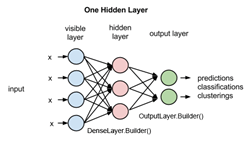

Each node (the circles) in the hidden layer represents a feature of a handwritten digit in the MNIST dataset. For example, imagine you are looking at the number 6. One node may represent rounded edges, another node may represent the intersection of curly lines, and so on and so forth. Such features are weighted by importance by the model's coefficients, and recombined in each hidden layer to help predict whether the handwritten number is indeed 6. The more layers of nodes you have, the more complexity and nuance they can capture to make better predictions.

You could think of a layer as "hidden" because, while you can see the input entering a net, and the decisions coming out, it’s difficult for humans to decipher how and why a neural net processes data on the inside. The parameters of a neural net model are simply long vectors of numbers, readable by machines.

In [7]:
val outputNum = EmnistDataSetIterator.numLabels(emnistSet) // total output classes
val rngSeed = 123 // integer for reproducability of a random number generator
val numRows = 28 // number of "pixel rows" in an mnist digit
val numColumns = 28

val conf = new NeuralNetConfiguration.Builder()
            .seed(rngSeed)
            .optimizationAlgo(OptimizationAlgorithm.STOCHASTIC_GRADIENT_DESCENT)
            .updater(new Adam())
            .l2(1e-4)
            .list()
            .layer(new DenseLayer.Builder()
                .nIn(numRows * numColumns) // Number of input datapoints.
                .nOut(1000) // Number of output datapoints.
                .activation(Activation.RELU) // Activation function.
                .weightInit(WeightInit.XAVIER) // Weight initialization.
                .build())
            .layer(new OutputLayer.Builder(LossFunctions.LossFunction.NEGATIVELOGLIKELIHOOD)
                .nIn(1000)
                .nOut(outputNum)
                .activation(Activation.SOFTMAX)
                .weightInit(WeightInit.XAVIER)
                .build())
            .pretrain(false).backprop(true)
            .build()

### Train the model

Now that we've built a `NeuralNetConfiguration`, we can use the configuration to instantiate a `MultiLayerNetwork`. When we call the `init()` method on the network, it applies the chosen weight initialization across the network and allows us to pass data to train. If we want to see the loss score during training, we can also pass a listener to the network.

An instantiated model has a `fit()` method that accepts a dataset iterator (an iterator that extends `BaseDatasetIterator`), a single `DataSet`, or an ND-Array (an implementation of `INDArray`). Since our EMNIST iterator already extends the iterator base class, we can pass it directly to fit. If we want to train for multiple epochs, DL4J also provides a `MultipleEpochsIterator` class that can handle multiple epochs for us.

In [9]:
// create the MLN
val network = new MultiLayerNetwork(conf)
network.init()

// pass a training listener that reports score every 10 iterations
val eachIterations = 5
network.addListeners(new ScoreIterationListener(eachIterations))

// fit a dataset for a single epoch
// network.fit(emnistTrain)

// fit for multiple epochs
// val numEpochs = 2
// network.fit(new MultipleEpochsIterator(numEpochs, emnistTrain))

### Evaluate the model

Deeplearning4j exposes several tools to [evaluate the performance](https://deeplearning4j.org/evaluation) of a model. You can perform basic evaluation and get metrics such as precision and accuracy, or use a Receiver Operating Characteristic (ROC). Note that the general `ROC` class works for binary classifiers, whereas `ROCMultiClass` is meant for classifiers such as the model we are building here.

A `MultiLayerNetwork` conveniently has a few methods built-in to help us perform evaluation. You can pass a dataset iterator with your testing/validation data to an `evaluate()` method.

In [11]:
// evaluate basic performance
val eval = network.evaluate(emnistTest)
eval.accuracy()
eval.precision()
eval.recall()

// evaluate ROC and calculate the Area Under Curve
val roc = network.evaluateROCMultiClass(emnistTest)
roc.calculateAverageAUC()

val classIndex = 0
roc.calculateAUC(classIndex)

// optionally, you can print all stats from the evaluations
print(eval.stats())
print(roc.stats())

# What's next

Now that you've learned how to get started and train your first model, head to the Deeplearning4j website to see [all the other tutorials](https://deeplearning4j.org/tutorials) that await you. Learn how to build dataset iterators, train a facial recognition network like FaceNet, and more.